Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Updating the paths of the train and test dataset accordingly
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin_cancer_ISIC/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Skin_cancer_ISIC/Test')

In [ ]:
# Checking the count of images in Train and Test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'Train image count - {image_count_train}')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'Test image count - {image_count_test}')

Train image count - 2249
Test image count - 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
# Loading the images with Batch Size - 32 and then resizing them to 180*180
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size= batch_size,
                                                               image_size=(img_height, img_width), validation_split=0.2, subset="training", seed=123, verbose = True)


Found 6749 files belonging to 9 classes.
Using 5400 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size= batch_size,
                                                               image_size=(img_height, img_width), validation_split=0.2, subset="validation", seed=123, verbose = True)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
# Normalize pixel values to be between 0 and 1
# Normalizing the images
def normalize(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

train_ds_vis = train_ds.map(normalize)
val_ds_vis = val_ds.map(normalize)

In [ ]:
# Collect one image each for every class

def collect_one_image_per_class(dataset, class_names):
    # Dictionary to track if we've already picked one image per class
    class_to_image = {cls: None for cls in class_names}

    for images, labels in dataset:
        for img, label in zip(images, labels):
            class_name = class_names[label.numpy()]
            if class_to_image[class_name] is None:  # If we haven't picked for this class yet
                class_to_image[class_name] = img
            if None not in class_to_image.values():  # Check if all classes have images
                break
        if None not in class_to_image.values():  # Break when all classes have images
           break
    return class_to_image

# start collecting one image per class
class_samples = collect_one_image_per_class(train_ds_vis, class_names)

In [ ]:
# Visualize image samples
import matplotlib.pyplot as plt

# Function to plot sample images
def plot_sample_images(class_samples, class_names):
    # Plot one image per class
    num_classes = len(class_names)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
    for i, class_name in enumerate(class_names):
        ax = axes[i]
        ax.imshow(class_samples[class_name].numpy())
        ax.set_title(class_name, fontsize=10, fontdict = {'horizontalalignment': 'center'})
        ax.axis("off")
    plt.tight_layout()
    plt.show()

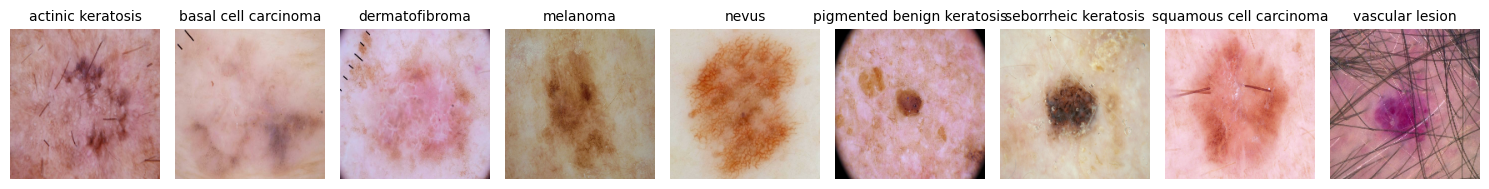

In [ ]:
plot_sample_images(class_samples, class_names)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
len(train_ds)

169

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, (3,3),input_shape=(28,28,1),activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(16, (3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(8, (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(layers.BatchNormalization())
# add drop out layer
model.add(layers.Dropout(0.30))

model.add(Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 87, 87, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 87, 87, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 41, 41, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 13448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         860,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 868,449 (3.31 MB)

 Trainable params: 868,225 (3.31 MB)

 Non-trainable params: 224 (896.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = True
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.3393 - loss: 2.1332 - val_accuracy: 0.1492 - val_loss: 2.8804
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4684 - loss: 1.5848 - val_accuracy: 0.1492 - val_loss: 2.8958
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5244 - loss: 1.3810 - val_accuracy: 0.1514 - val_loss: 3.0474
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5845 - loss: 1.1975 - val_accuracy: 0.1537 - val_loss: 2.8525
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6571 - loss: 1.0085 - val_accuracy: 0.2628 - val_loss: 2.2012
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7143 - loss: 0.8712 - val_accuracy: 0.2027 - val_loss: 2.9173
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8312 - loss: 0.5521 - val_accuracy: 0.2717 - val_loss: 2.8801
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8663 - loss: 0.4333 - val_accuracy: 0.3563 - 

### Visualizing training results

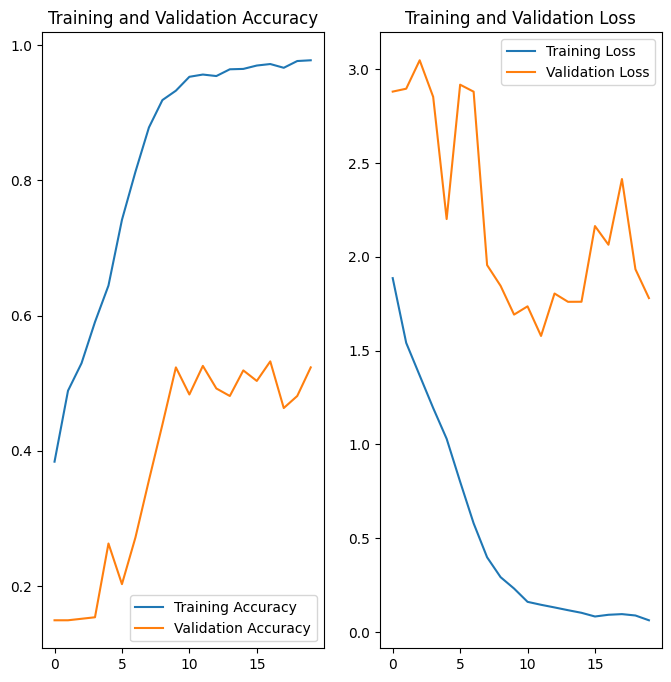

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### --> The model is Overfitting since the training accuracy (approx 0.98) is very high compared to the validation accuracy (aprrox 0.52)

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

# The First model is overfitting. Therefore Implementing data augmentation using Keras to create more data points for training

# Since the images of the cancer are not dependent on "Horizontal or Vertical" orientation, using "Horizontal or Vertical" augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Applying data augmentation within the dataset pipeline
def augment_data(image, label):
    augmented_image = data_augmentation(image)
    return augmented_image, label

# Apply augmentation to the training dataset
augmented_train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

Text(0.5, 1.0, 'melanoma - Augmented')

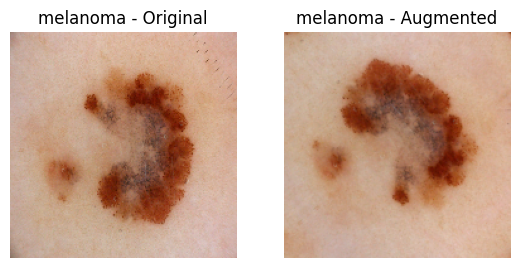

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

for images, labels in train_ds:
    image_org = images[0]*1.0/255
    label_org = labels[0]
    break

image_org = tf.cast(tf.expand_dims(image_org, 0), tf.float32)

plt.figure(figsize=(10, 10))
original_image = image_org
ax = plt.subplot(3, 3, 1)
plt.imshow(original_image[0])
plt.axis("off")
plt.title(class_names[label_org] + ' - Original')

augmented_image = augment_data(image_org, label_org)[0]
ax = plt.subplot(3, 3, 2)
plt.imshow(augmented_image[0])
plt.axis("off")
plt.title(class_names[label_org] + ' - Augmented')

### Todo:
### Create the model, compile and train the model

#### Training the model ONLY on Augmented data


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, (3,3),input_shape=(28,28,1),activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(16, (3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(8, (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(layers.BatchNormalization())
# add drop out layer
model.add(layers.Dropout(0.30))

model.add(Dense(9,activation='softmax'))



### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 87, 87, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 87, 87, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 41, 41, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 13448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │         860,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 868,449 (3.31 MB)

 Trainable params: 868,225 (3.31 MB)

 Non-trainable params: 224 (896.00 B)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs

## Training using the Augmented image dataset and the original validation dataset
epochs = 20
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = True
)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.4555 - loss: 1.8890 - val_accuracy: 0.3096 - val_loss: 4.0341
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.4535 - loss: 1.5652 - val_accuracy: 0.3541 - val_loss: 3.6374
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.5102 - loss: 1.4207 - val_accuracy: 0.3563 - val_loss: 2.4800
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.5083 - loss: 1.3884 - val_accuracy: 0.3964 - val_loss: 1.7905
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.5329 - loss: 1.3027 - val_accuracy: 0.4543 - val_loss: 1.5959
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.5280 - loss: 1.3446 - val_accuracy: 0.4143 - val_loss: 1.7955
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.5269 - loss: 1.3139 - val_accuracy: 0.4610 - val_loss: 1.7550
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.5383 - loss: 1.2960 - val_accuracy: 

### Visualizing the results

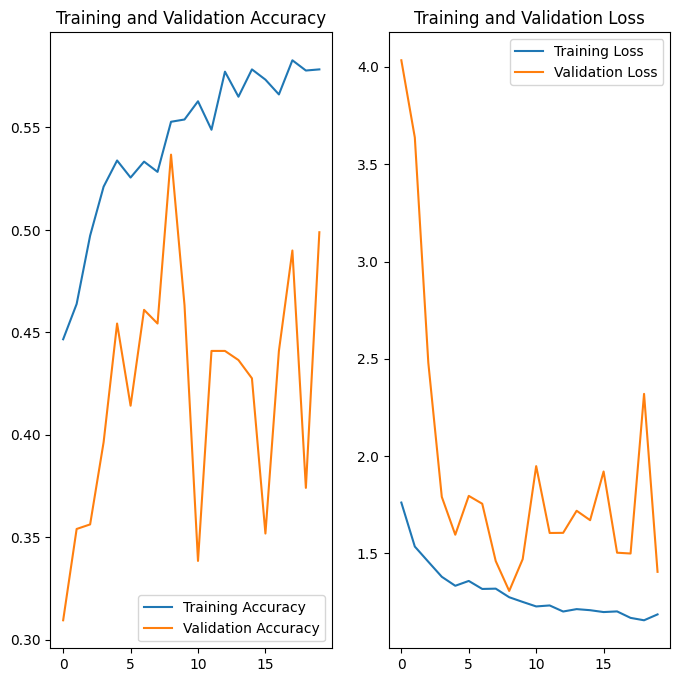

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Findings : The Overfitting is reduced now since the difference between the training accuracy and the validation accuracy is reduced.

#### But, the model now seems to Underfit as both the training and validation accuracy are low.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
## Your code goes here.
labels_list=[]
for images, labels in train_ds:
  for lbl in labels:
            labels_list.append(class_names[lbl.numpy()])

pd.DataFrame(np.unique(labels_list, return_counts = True))

,0,1,2,3,4,5,6,7,8
0,actinic keratosis,basal cell carcinoma,dermatofibroma,melanoma,nevus,pigmented benign keratosis,seborrheic keratosis,squamous cell carcinoma,vascular lesion
1,88,309,77,354,276,380,62,137,117


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
##### Ans - seborrheic keratosis (62 samples in train dataset)

#### - Which classes dominate the data in terms proportionate number of samples?
##### Ans - basal cell carcinoma, melanoma, pigmented benign keratosis and nevus


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset= "/content/gdrive/My Drive/Skin_cancer_ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DF454E16470>: 100%|██████████| 500/500 [00:20<00:00, 24.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF454DF2BF0>: 100%|██████████| 500/500 [00:21<00:00, 23.11 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF454B22D40>: 100%|██████████| 500/500 [00:19<00:00, 25.23 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer_ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DF443F01A20>: 100%|██████████| 500/500 [01:29<00:00,  5.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer_ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF443FCBDC0>: 100%|██████████| 500/500 [01:23<00:00,  5.96 Samples/s]


Initialised with 472 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF454C69540>: 100%|██████████| 500/500 [00:19<00:00, 25.58 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DF454B21930>: 100%|██████████| 500/500 [00:42<00:00, 11.75 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF45008C850>: 100%|██████████| 500/500 [00:19<00:00, 25.25 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DF4500841F0>: 100%|██████████| 500/500 [00:20<00:00, 24.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029781.jpg_fddaf614-0fc3-4c4d-8d44-8f6f3945e461.jpg',
 '/content/gdrive/My Drive/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_cb2371c8-9bdf-49d4-9cf5-17c1a2528caa.jpg',
 '/content/gdrive/My Drive/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_68286f0e-4a78-4de0-945b-93aa6fffb9cf.jpg',
 '/content/gdrive/My Drive/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_c66175a0-09e7-41c4-ba6b-11ba8fc73737.jpg',
 '/content/gdrive/My Drive/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_c9646047-23e2-45d9-a7db-cde6445517b6.jpg',
 '/content/gdrive/My Drive/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_472274a1-905e-4e38-928a-ba1202a3d9ae.jpg',
 '/content/gdrive/My Drive/S

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
new_df = df2

In [ ]:
new_df['Label'].value_counts()

,count
Label,
actinic keratosis,500
nevus,500
dermatofibroma,500
squamous cell carcinoma,500
seborrheic keratosis,500
pigmented benign keratosis,500
basal cell carcinoma,500
melanoma,500
vascular lesion,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train= "/content/gdrive/My Drive/Skin_cancer_ISIC/Train/"
aug_org_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="training", verbose = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
aug_org_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", verbose = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

## Creating Final model using both Augmented + Original data

In [ ]:
## your code goes here

model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(16, (3,3),input_shape=(28,28,1),activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(Conv2D(8, (3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(Conv2D(8, (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(layers.BatchNormalization())
# add drop out layer
model.add(layers.Dropout(0.50))

model.add(Dense(9,activation='softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 178, 178, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 87, 87, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 87, 87, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 43, 43, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 41, 41, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 13448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         860,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 863,865 (3.30 MB)

 Trainable params: 863,689 (3.29 MB)

 Non-trainable params: 176 (704.00 B)

#### **Todo:**  Train your model

In [ ]:
epochs = 20
## Your code goes here, use 20 epochs.
history = model.fit(
  aug_org_train_ds,
  validation_data = aug_org_val_ds,
  epochs=epochs,
  verbose = True
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 675s 4s/step - accuracy: 0.2479 - loss: 2.2322 - val_accuracy: 0.1223 - val_loss: 3.3849
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - accuracy: 0.4098 - loss: 1.5859 - val_accuracy: 0.1386 - val_loss: 2.7089
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 225ms/step - accuracy: 0.4674 - loss: 1.4329 - val_accuracy: 0.3158 - val_loss: 3.8822
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - accuracy: 0.5158 - loss: 1.3232 - val_accuracy: 0.4418 - val_loss: 1.5582
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - accuracy: 0.5520 - loss: 1.2577 - val_accuracy: 0.3388 - val_loss: 2.7468
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.5780 - loss: 1.1667 - val_accuracy: 0.5367 - val_loss: 1.2694
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.6094 - loss: 1.0454 - val_accuracy: 0.5678 - val_loss: 1.1838
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step - accuracy: 0.6459 - loss: 0.9
















































#### **Todo:**  Visualize the model results

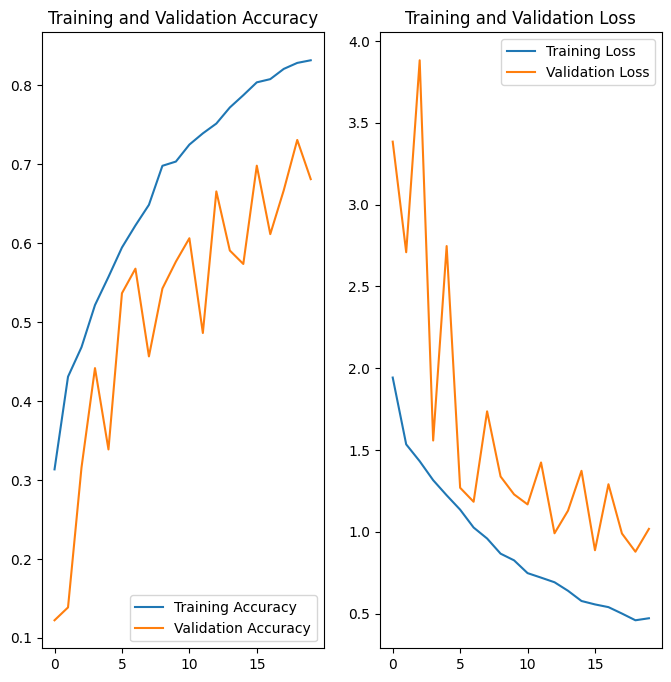

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

##### The level of underfitting/overfitting has reduced a lot. The train and validation accuracy numbers are quite high now (reduced underfitting). Also, the difference between Train and Validation accuracy has reduced by a lot (reduced overfitting).

##### YES, Class rebalance helped a lot
